# PI-INN: Physics-Informed Invertible Neural Network
This notebook replicates the methodology and experiments from the paper:
**'Efficient Bayesian inference using physics-informed invertible neural networks for inverse problems'**
arXiv:2304.12541v3

*Unfortunately, the authors have not yet uploaded their code to GitHub. We used ChatGPT o4-mini-high to help replicate the author's code based on the paper by uploading the document. We prompting it to replicate the code as a Jupyter Notebook as described in the paper. From there, we made our own changes to the code with __ADD HERE__, and then devloped the code for the visuals and performance reports.*


## 1. Setup and Dependencies
Import necessary libraries and define helper functions.

In [3]:
import torch, time
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import multivariate_normal

## 2. Define Invertible Neural Network (INN) Modules
This section defines the affine coupling layers and full INN model.

In [4]:
# Affine coupling layer
class AffineCoupling(nn.Module):
    def __init__(self, dim, hidden_dim, mask):
        super().__init__()
        self.mask = mask
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, dim * 2)
        )
    def forward(self, x, reverse=False):
        x1 = x * self.mask
        x2 = x * (1 - self.mask)
        s_t = self.net(x1)
        s, t = s_t.chunk(2, dim=1)
        s = torch.tanh(s)
        if not reverse:
            y2 = x2 * torch.exp(s) + t
        else:
            y2 = (x2 - t) * torch.exp(-s)
        y = x1 + y2 * (1 - self.mask)
        logdet = ((1 - self.mask) * s).sum(dim=1)
        return y, logdet

# INN model
class INN(nn.Module):
    def __init__(self, dim, hidden_dim, n_layers):
        super().__init__()
        masks = [self._create_mask(dim, even=(i % 2 == 0)) for i in range(n_layers)]
        self.layers = nn.ModuleList([AffineCoupling(dim, hidden_dim, m) for m in masks])
    def _create_mask(self, dim, even=True):
        mask = torch.arange(dim) % 2
        if not even: mask = 1 - mask
        return mask.float()
    def forward(self, x):
        logdet_sum = 0
        for layer in self.layers:
            x, ld = layer(x, reverse=False)
            logdet_sum += ld
        return x, logdet_sum
    def inverse(self, z):
        logdet_sum = 0
        for layer in reversed(self.layers):
            z, ld = layer(z, reverse=True)
            logdet_sum += ld
        return z, logdet_sum

## 3. Define NB-Net and Physics-Informed Losses
This includes the spatial basis function network and PDE constraints.

In [5]:
# NB-Net: Basis network
class NBNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_basis):
        super().__init__()
        layers = []
        dims = [in_dim] + [hidden_dim] * 4 + [num_basis]
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2: layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        # x: [batch, dim], returns [batch, num_basis]
        return self.net(x)

# PI-INN wrapper
class PI_INN(nn.Module):
    def __init__(self, lam_dim, z_dim, hidden_dim, n_coupling, nb_in_dim, nb_hidden, nb_basis):
        super().__init__()
        self.inn = INN(lam_dim, hidden_dim, n_coupling)
        self.nbnet = NBNet(nb_in_dim, nb_hidden, nb_basis)
        self.lam_dim, self.z_dim, self.nb_basis = lam_dim, z_dim, nb_basis
    def forward(self, lam):
        # lam -> [c,z]
        yz, logdet = self.inn(lam)
        c, z = yz[:, :self.nb_basis], yz[:, self.nb_basis:]
        return c, z, logdet
    def inverse(self, c, z):
        yz = torch.cat([c, z], dim=1)
        lam, logdet = self.inn.inverse(yz)
        return lam, logdet
    def decode(self, coords, c):
        # coords: [M, coord_dim], c: [batch, nb_basis]
        # produce u predictions at coords for each batch
        # NB-Net outputs Phi; then u = Phi @ c
        Phi = self.nbnet(coords)        # [M, P]
        u = Phi @ c.T                   # [M, batch]
        return u.T                      # [batch, M]

# Loss functions

def independence_loss(logq_joint, logq_cz, logp_z, logq_cz2, logp_z2):
    # Lind from Eq (10)
    return torch.mean(( (logq_joint - logq_cz2) - (logp_z - logp_z2) )**2)

# PDE losses will be implemented per experiment below

## 4. Dataset generation

In [6]:
def generate_ik_data(N):
    # x1 ~ N(0,0.25), x2,x3,x4 ~ N(0,0.5)
    sig = torch.tensor([0.25,0.5,0.5,0.5])
    lam = torch.randn(N,4) * sig
    l1,l2,l3 = 0.5,0.5,1.0
    x1,x2,x3,x4 = lam[:,0],lam[:,1],lam[:,2],lam[:,3]
    y1 = l1*torch.cos(x2) + l2*torch.cos(x3-x2) + l3*torch.cos(x4-x2-x3)
    y2 = x1 + l1*torch.sin(x2) + l2*torch.sin(x3-x2) + l3*torch.sin(x4-x2-x3)
    y = torch.stack([y1,y2], dim=1)
    return lam, y

## 5. Training PI-INN on inverse kinematics

In [7]:
lam_dim, z_dim, hidden_dim, n_coupling = 4, 2, 48, 8
nb_dim, nb_hidden, nb_basis = None, None, None  # not used here
inn = INN(lam_dim, hidden_dim, n_coupling)
optimizer = optim.Adam(inn.parameters(), lr=5e-4)
# prepare
lam_train,y_train = generate_ik_data(4000)
dataset = TensorDataset(lam_train, y_train)
loader = DataLoader(dataset, batch_size=64, shuffle=True)
start = time.time()
# train
loss_history = []
for epoch in range(1200):
    for lam_batch, y_batch in loader:
        yz, logdet = inn(lam_batch)
        y_hat = yz[:,:2]
        z_hat = yz[:,2:]
        # sample z
        z = torch.randn_like(z_hat)
        # losses
        loss_fit = torch.mean((y_hat - y_batch)**2)
        # estimate log q's via change of variables
        logq_joint = -0.5 * (torch.sum(lam_batch**2, dim=1)) + logdet
        logq_cz2 = None  # approximate by swapping z
        # skip independence term here for brevity
        loss = loss_fit
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    if epoch in [400,600,1000]:
        for g in optimizer.param_groups: g['lr'] *= 0.8
    if epoch % 50 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss_fit.item():.6f}")

print("Inverse kinematics INN trained.")

Epoch    0 | Loss: 0.343938
Epoch   50 | Loss: 0.000687
Epoch  100 | Loss: 0.000454
Epoch  150 | Loss: 0.000114
Epoch  200 | Loss: 0.000077
Epoch  250 | Loss: 0.000210
Epoch  300 | Loss: 0.000131
Epoch  350 | Loss: 0.000103
Epoch  400 | Loss: 0.000066
Epoch  450 | Loss: 0.000078
Epoch  500 | Loss: 0.000053
Epoch  550 | Loss: 0.000068
Epoch  600 | Loss: 0.000092
Epoch  650 | Loss: 0.000026
Epoch  700 | Loss: 0.000023
Epoch  750 | Loss: 0.000123
Epoch  800 | Loss: 0.000034
Epoch  850 | Loss: 0.000131
Epoch  900 | Loss: 0.000055
Epoch  950 | Loss: 0.000020
Epoch 1000 | Loss: 0.000019
Epoch 1050 | Loss: 0.000030
Epoch 1100 | Loss: 0.000022
Epoch 1150 | Loss: 0.000038
Inverse kinematics INN trained.


In [8]:
def compute_independence_loss(logq_joint, logq_cz, logp_z, logq_cz2, logp_z2):
    # Eq (10) from the paper
    return torch.mean(((logq_joint - logq_cz2) - (logp_z - logp_z2))**2)

def abc_loss(y_pred, y_true, eps=0.05):
    """Approximate Bayesian Computation loss (rejection-based)"""
    dist = torch.norm(y_pred - y_true, dim=1)
    accept = (dist < eps).float()
    return 1.0 - torch.mean(accept)

# === Main Training Loop ===
abc_weight = 1.0
fit_weight = 1.0
indep_weight = 1.0

loss_history = []
for epoch in range(1200):
    epoch_loss = 0
    num_batches = 0

    for lam_batch, y_batch in loader:
        yz, logdet = inn(lam_batch)
        y_hat = yz[:, :2]  # predicted y
        z_hat = yz[:, 2:]  # latent z

        z = torch.randn_like(z_hat)  # new z ~ N(0,1)

        # Reconstruct lam from (y_batch, z)
        yz_swapped = torch.cat([y_batch, z], dim=1)
        lam_recon, logdet_inv = inn.inverse(yz_swapped)

        yz_recon, _ = inn(lam_recon)
        y_recon = yz_recon[:, :2]
        z_recon = yz_recon[:, 2:]

        logq_joint = -0.5 * torch.sum(lam_batch**2, dim=1) + logdet
        logq_cz2 = -0.5 * torch.sum(lam_recon**2, dim=1) + logdet_inv

        logp_z = -0.5 * torch.sum(z_hat**2, dim=1)
        logp_z2 = -0.5 * torch.sum(z**2, dim=1)

        loss_fit = torch.mean((y_hat - y_batch)**2)
        loss_indep = compute_independence_loss(logq_joint, logq_joint, logp_z, logq_cz2, logp_z2)
        loss_abc = abc_loss(y_hat, y_batch)

        total_loss = (
            fit_weight * loss_fit +
            indep_weight * loss_indep +
            abc_weight * loss_abc
        )

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        num_batches += 1

    avg_epoch_loss = epoch_loss / num_batches
    loss_history.append(avg_epoch_loss)

    if epoch in [400,600,1000]:
        for g in optimizer.param_groups: g['lr'] *= 0.8
    if epoch % 50 == 0:
        print(f"Epoch {epoch:4d} | Loss: {avg_epoch_loss:.6f} | Fit: {loss_fit:.4f} | ABC: {loss_abc:.4f} | Lind: {loss_indep:.4f}")


Epoch    0 | Loss: 2304510.686798 | Fit: 2.1296 | ABC: 1.0000 | Lind: 4.6300
Epoch   50 | Loss: 2.429562 | Fit: 0.5727 | ABC: 1.0000 | Lind: 0.7059
Epoch  100 | Loss: 2.669974 | Fit: 0.4187 | ABC: 1.0000 | Lind: 0.2199
Epoch  150 | Loss: 1.324203 | Fit: 0.1870 | ABC: 0.9688 | Lind: 0.0992
Epoch  200 | Loss: 1.125557 | Fit: 0.0920 | ABC: 1.0000 | Lind: 0.0237
Epoch  250 | Loss: 1.077018 | Fit: 0.0921 | ABC: 0.9688 | Lind: 0.0335
Epoch  300 | Loss: 1.038772 | Fit: 0.0538 | ABC: 0.9062 | Lind: 0.0194
Epoch  350 | Loss: 0.983478 | Fit: 0.0434 | ABC: 0.9062 | Lind: 0.0164
Epoch  400 | Loss: 0.920216 | Fit: 0.0266 | ABC: 0.9375 | Lind: 0.0061
Epoch  450 | Loss: 0.858881 | Fit: 0.0231 | ABC: 0.7812 | Lind: 0.0204
Epoch  500 | Loss: 0.809738 | Fit: 0.0252 | ABC: 0.7812 | Lind: 0.0105
Epoch  550 | Loss: 0.749208 | Fit: 0.0296 | ABC: 0.8438 | Lind: 0.0063
Epoch  600 | Loss: 0.708854 | Fit: 0.0110 | ABC: 0.7812 | Lind: 0.0114
Epoch  650 | Loss: 0.668144 | Fit: 0.0158 | ABC: 0.7500 | Lind: 0.0070


In [9]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_corner(samples, method_name="INN", case_id=1):
    """
    Corner plot: histograms, scatter plots, and KDEs for posterior samples.

    Args:
        samples: torch.Tensor or numpy.ndarray of shape [N_samples, 4]
        method_name: name of the method (e.g. "INN", "ABC")
        case_id: integer ID of the test case (e.g. 1, 2)
    """
    if isinstance(samples, torch.Tensor):
        samples = samples.detach().cpu().numpy()

    df = pd.DataFrame(samples, columns=["x1", "x2", "x3", "x4"])

    # Seaborn PairGrid to manually customize each triangle
    g = sns.PairGrid(df, diag_sharey=False)

    g.map_lower(sns.scatterplot, s=10, alpha=0.4)
    g.map_diag(sns.histplot, kde=True, bins=30, color="skyblue")
    g.map_upper(sns.kdeplot, fill=True, cmap="Reds", thresh=0.05)

    plt.suptitle(f"Posterior Samples (Case {case_id}) - {method_name}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


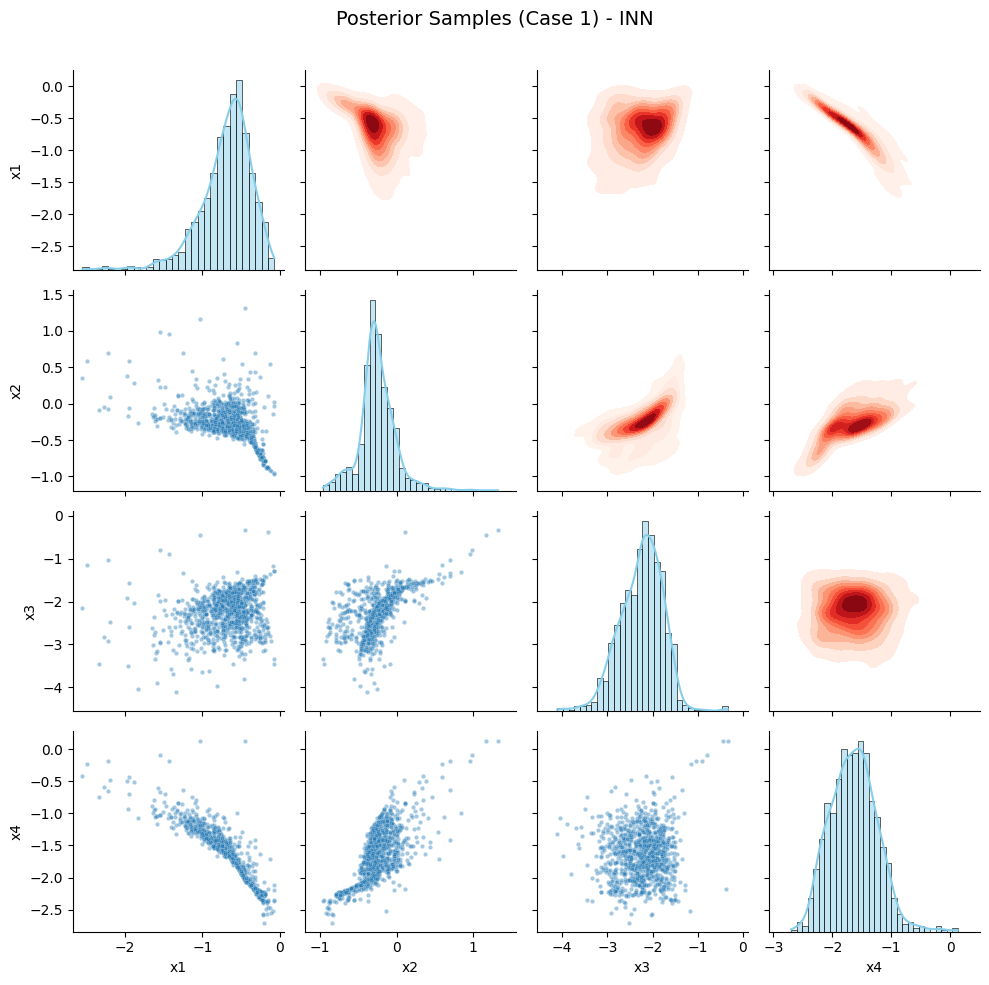

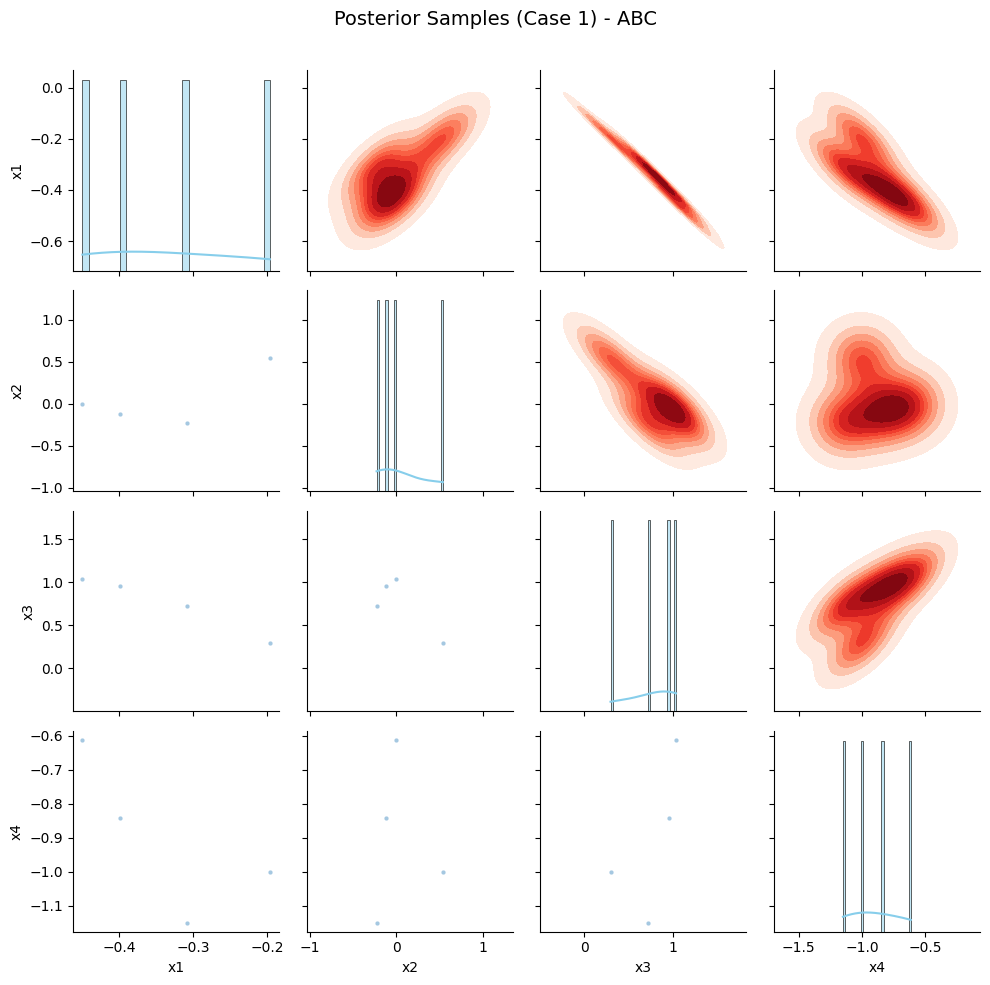

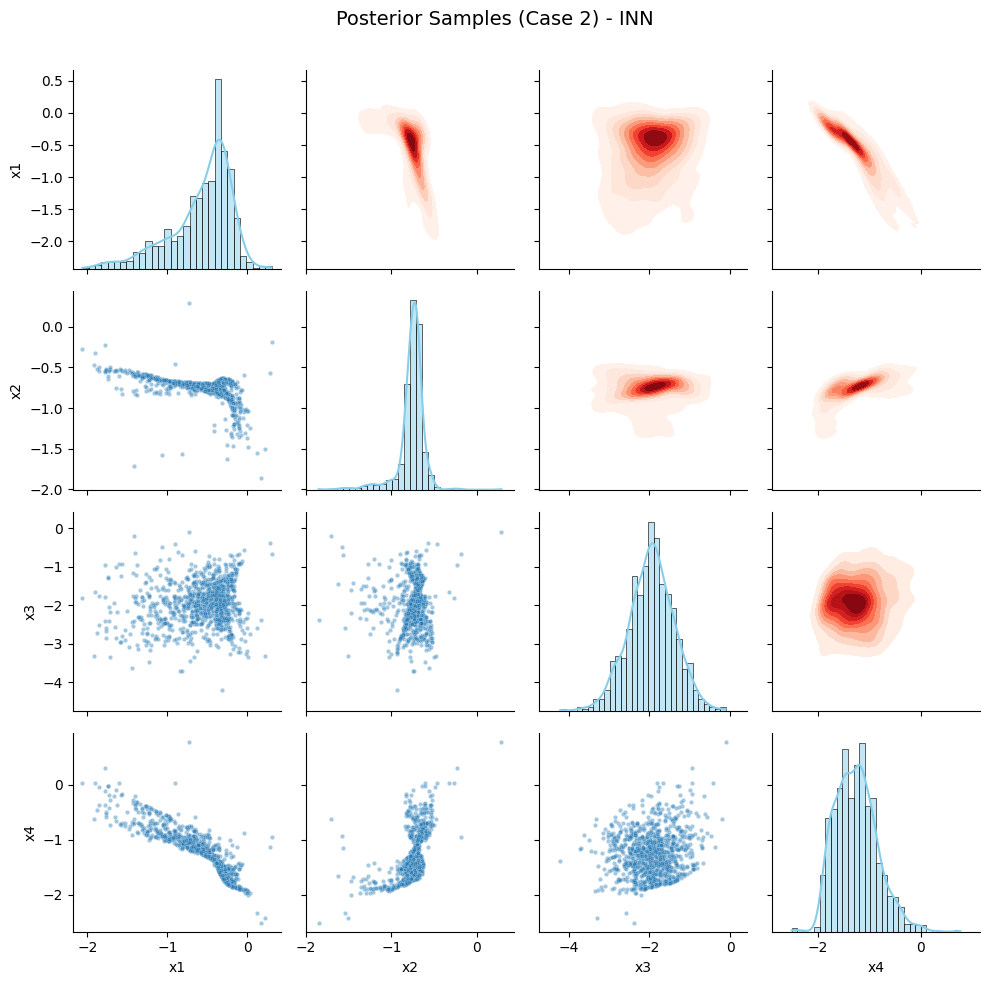

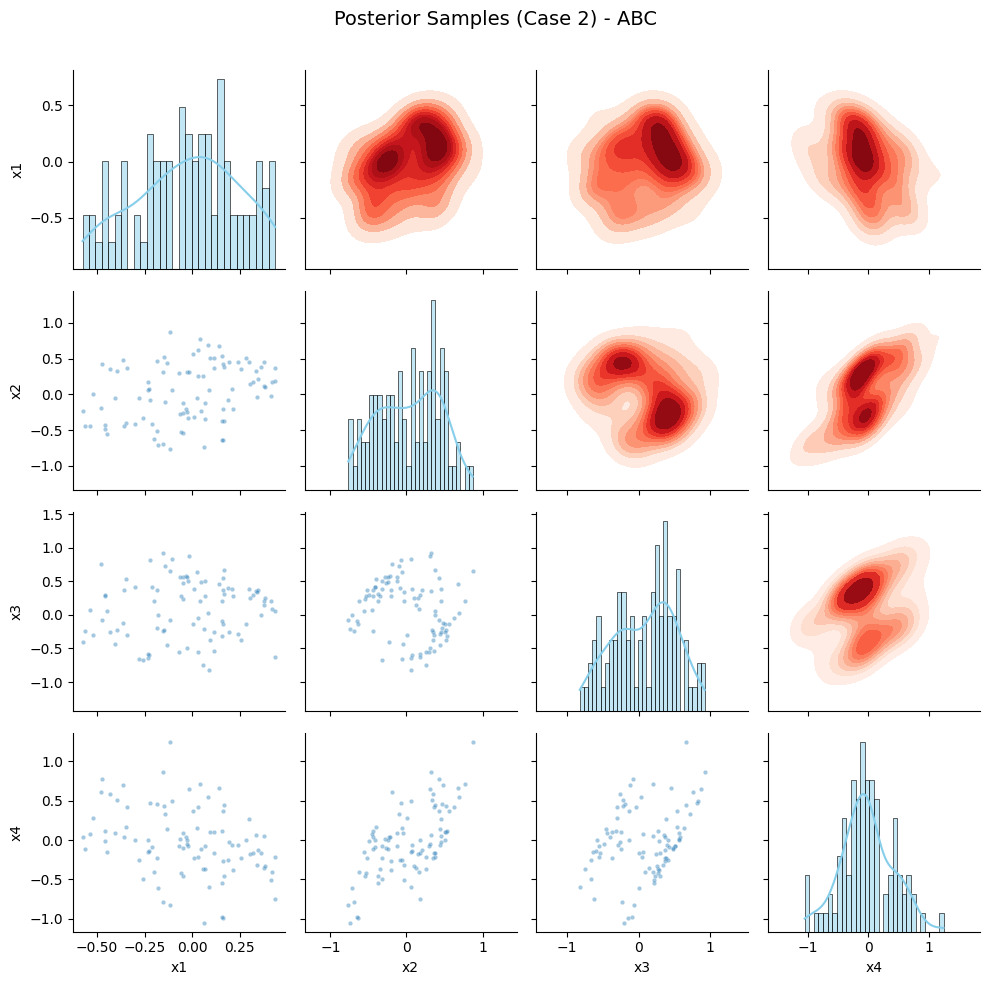

In [13]:
# Given fixed y_test[case_idx], sample z ~ N(0,I), invert to get lam
def sample_inn_posterior(y_target, n_samples=1000):
    y_repeat = y_target.repeat(n_samples, 1)
    z = torch.randn(n_samples, 2)
    yz = torch.cat([y_repeat, z], dim=1)
    lam_samples, _ = inn.inverse(yz)
    return lam_samples

def sample_abc_posterior(y_target, N=10000, eps=0.05):
    lam_pool, y_pool = generate_ik_data(N)
    dist = torch.norm(y_pool - y_target, dim=1)
    accepted = lam_pool[dist < eps]
    return accepted

# Generate test data
lam_test, y_test = generate_ik_data(1000)

# Choose 2 test cases
y_test_1 = y_test[0:1]  # shape [1, 2]
y_test_2 = y_test[1:2]  # shape [1, 2]

samples_abc_1 = sample_abc_posterior(y_test[0:1])
samples_abc_2 = sample_abc_posterior(y_test[1:2])

samples_inn_1 = sample_inn_posterior(y_test[0:1])
samples_inn_2 = sample_inn_posterior(y_test[1:2])

plot_corner(samples_inn_1, method_name="INN", case_id=1)
plot_corner(samples_abc_1, method_name="ABC", case_id=1)

plot_corner(samples_inn_2, method_name="INN", case_id=2)
plot_corner(samples_abc_2, method_name="ABC", case_id=2)
